# L2 - Multilayer perceptron

### Papers
1. [TensorFlow](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/45166.pdf)

### TensorFlow
1. [Installing TensorFlow](https://www.tensorflow.org/install/)
2. [Basics of TensorFlow](https://www.tensorflow.org/get_started/get_started)
3. [Mnist with TensorFlow](https://www.tensorflow.org/get_started/mnist/pros)
4. [TensorFlow Mechanics](https://www.tensorflow.org/get_started/mnist/mechanics)
5. [Visualization](https://www.tensorflow.org/get_started/graph_viz)


### One more thing
1. [Jupyter tutorial](https://habrahabr.ru/company/wunderfund/blog/316826/)
2. [Plot.ly](https://plot.ly/python/)
3. [Widgets](http://jupyter.org/widgets.html)

### 1. Linear multi-classification problem

We have already learned binary linear classifier
$$y = \text{sign}(w^Tx).$$
There are [several approaches](https://en.wikipedia.org/wiki/Multiclass_classification) to solve the problem of multi-class classification. For example [reduction](https://en.wikipedia.org/wiki/Multiclass_classification#Transformation_to_Binary) of problem to binary classifier or [modification](https://en.wikipedia.org/wiki/Support_vector_machine#Multiclass_SVM) of the known model. However we are interested in approaches that is applied in neural networks.

For each class $c \in 1, \dots, |C|$ we have an individual row $w_i$ of matrix $W$. Then the probability of $x$ belonging to a particular class is equal to
$$p_i = \frac{\exp(w^T_ix)}{\sum_j \exp(w^T_jx)}.$$
This is nothing, but [softmax](https://en.wikipedia.org/wiki/Softmax_function) function of $Wx$.
$$(p_1, \dots, p_{|C|}) = \text{softmax}(Wx).$$

If you look closely, $\text{softmax}$ is a more general variant of sigmoid. To see this, it suffices to consider the case $|C|=2$. As usual the training can be reduced to minimization of the empirical risk, namely, optimization problem
$$\arg\min_W Q(W) = \arg\min_W -\frac{1}{\mathcal{l}}\sum_y\sum_i [y = i] \cdot \ln(p_i(W)).$$
Actually, the maximization of the log-likelihood is written above.

#### Exercises
1. Find $\frac{dQ}{dW}$ in matrix form (hint: start with $\frac{dQ}{dw_i}$ for begining).
2. Please plot several mnist images (e.g using grid 5x5).
3. Train linear multi-label classifier for [mnist](https://www.kaggle.com/c/digit-recognizer) dataset with TensorFlow (possible, [this tutorial](https://www.tensorflow.org/get_started/mnist/pros) can help you).
4. Chek accuracy on train and validation sets.
5. Use a local [TensorBoard instance](https://www.tensorflow.org/get_started/graph_viz) to visualize resulted graph (no need to include in lab).

Если мы обозначим конкретное $i$ для которого $[y = i]$ то наша функция потерь будет выглядеть так:

$$Q(W) = -\frac{1}{\mathcal{l}} \ln(p_i(W)) = -\frac{1}{\mathcal{l}} \ln{\frac{\exp(w^T_ix)}{\sum\limits_j \exp(w^T_jx)}} = -\frac{1}{\mathcal{l}} \big( \ln{(\exp(w^T_ix))} - \ln{(\sum\limits_j \exp(w^T_jx))} \big) = -\frac{1}{\mathcal{l}} \big( w^T_ix - \ln{(\sum\limits_j \exp(w^T_jx))} \big)$$

Возмём производную по $w_{ik}$:

$$\frac{dQ}{dw_{ik}} = -\frac{1}{\mathcal{l}} \big( x_k - \frac{\exp(w^T_ix)}{\sum\limits_j \exp(w^T_jx)} \cdot x_k \big) = -\frac{1}{\mathcal{l}} \big( x_k - p_i \cdot x_k \big)$$

Тогда по сути мы нашли $\frac{dQ}{dw_i} = -\frac{1}{\mathcal{l}} (x^T - p_ix^T)$ где умножение на $p_i$ поэлементное. Для остальных строчек производная будет выглядеть так же только без $x^T$ в начале и берём $j$ элемент софтмакса.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

In [28]:
mnist = pd.read_csv("train.csv", sep = ',')
mnist = mnist.sample(frac=1).values

def parse_data(l, r, data):
    X = data[l:r, 1:] / 255 + 0.5
    Y = data[l:r,0]
    return X, Y

train_X, train_Y = parse_data(0, int(len(mnist) * 0.7), mnist)
valid_X, valid_Y = parse_data(int(len(mnist) * 0.7), int(len(mnist) * 0.85), mnist)
test_X, test_Y = parse_data(int(len(mnist) * 0.85), len(mnist), mnist)
small_X, small_Y = parse_data(0, int(len(mnist) * 0.1), mnist)

feature_num = len(train_X[0])
label_num = 10

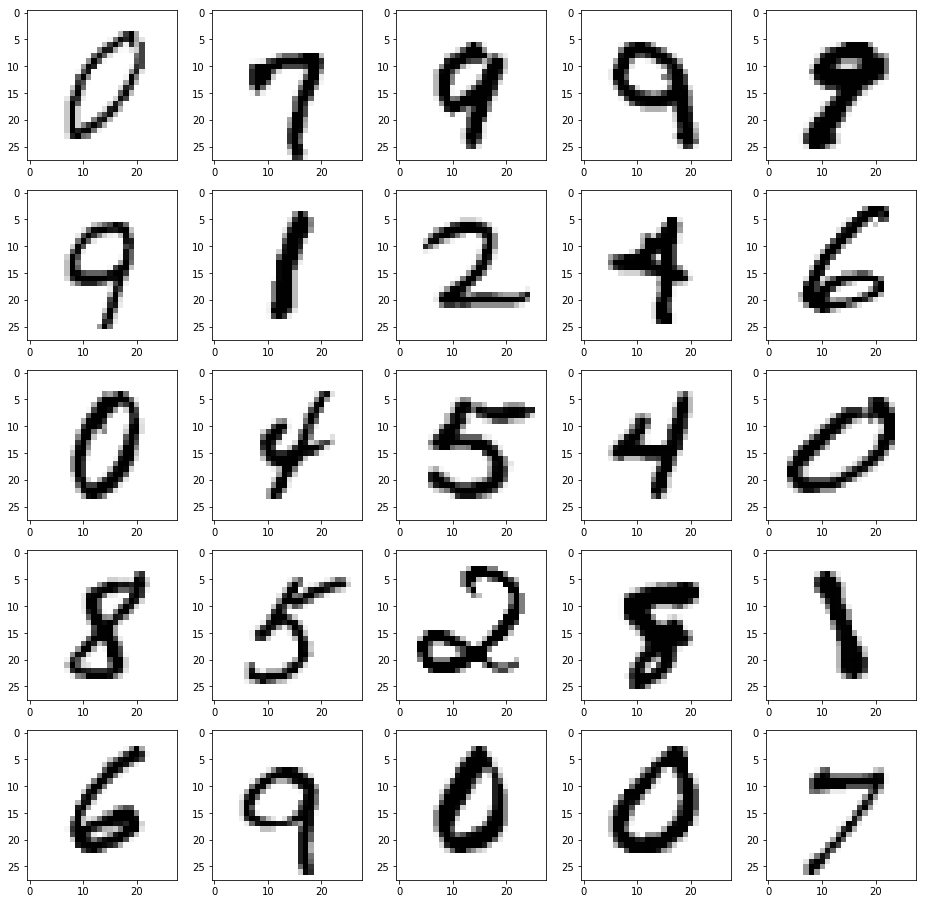

In [29]:
fig = plt.figure(figsize=(16, 16))

for i in range(5):
    for j in range(5):
        image = plt.subplot2grid((5, 5), (i, j))
        image.imshow(np.resize(train_X[5*i + j], (28, 28)), cmap='gray_r')

plt.show()

In [52]:
def get_param(shape, name=None):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1), name=name)

def get_train_batches(batch_size):
    batch_separators = tuple(np.arange(batch_size, len(train_X), batch_size))
    batch_X = np.vsplit(train_X, batch_separators)
    batch_Y = np.hsplit(train_Y, batch_separators)
    return batch_X, batch_Y

def optimize(alph=0.1, epochs=10, batch_size=100, info=False):
    batch_X, batch_Y = get_train_batches(batch_size)
    
    epochs_left = epochs
    while epochs_left:
        epochs_left -= 1
        for i in range(len(batch_X)):
            sess.run(train_step, feed_dict={x: batch_X[i], y_: batch_Y[i], alpha: alph})
        if info:
            print('Эпоха номер:', epochs - epochs_left)
            print('Точность на обучении:', sess.run(accuracy, feed_dict={x: batch_X[0], y_: batch_Y[0]}))
            print('Точность на валидации:', sess.run(accuracy, feed_dict={x: valid_X, y_: valid_Y}), '\n')
            
    print("Качество модели на обучении:", sess.run(accuracy, feed_dict={x: small_X, y_: small_Y}))
    print("Качество модели на валидации:", sess.run(accuracy, feed_dict={x: valid_X, y_: valid_Y}))
    print("Качество модели на тестировании:", sess.run(accuracy, feed_dict={x: test_X, y_: test_Y}))

In [31]:
graph = tf.Graph()
with graph.as_default():
    x = tf.placeholder(tf.float32, shape=[None, feature_num], name='Inputs')
    y_ = tf.placeholder(tf.int64, name='Answers')
    
    with tf.name_scope('Layer'):
        W = get_param([feature_num, label_num], 'Weights')
        b = get_param([label_num], 'Bias')
        matmul = tf.matmul(x, W) + b
        
    with tf.name_scope('Evaluation'):
        check_prediction = tf.equal(tf.argmax(matmul,1), y_, name='Check_prediction')
        accuracy = tf.reduce_mean(tf.cast(check_prediction, tf.float32), name='Accuracy')
        
    with tf.name_scope('Loss_function'):
        loss_function = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_, logits=matmul), name='Loss')
        
    with tf.name_scope('Trainig_step'):
        alpha = tf.placeholder(tf.float32, name='Alpha')
        train_step = tf.train.GradientDescentOptimizer(alpha).minimize(loss_function)
        
writer = tf.summary.FileWriter("logs/linear")
writer.add_graph(graph)

In [32]:
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    optimize(epochs=20, alph=0.1, batch_size=200)

Качество модели на обучении: 0.912619
Качество модели на валидации: 0.903666
Качество модели на тестировании: 0.907143


Let's briefly touch on themes of regularization. As was discussed before, there are different approaches. We focus on the modification of loss function.

$$\arg\min_W -\frac{1}{\mathcal{l}}\sum_y\sum_i [y = i] \cdot \ln(p_i(W)) + \lambda_1 L_1(W) + \lambda_2 L_2(W)$$

1. $L_1(W) = sum_{i,j} |w_{i,j}|$ - sparsify weights (force to not use uncorrelated features)
2. $L_2(W) = sum_{i,j} w_{i,j}^2$ - minimize weights (force to not overfit)

#### Exercises
1. Train model again using both type of regularization.
2. Plot matrix of weights.
3. Which pixels have zero weights? What does it mean?
4. Have you improved accuracy on validation?

In [7]:
lamb_1 = 0.00001
lamb_2 = 0.00001

graph = tf.Graph()
with graph.as_default():
    x = tf.placeholder(tf.float32, shape=[None, feature_num], name='Inputs')
    y_ = tf.placeholder(tf.int64, name='Answers')
    
    with tf.name_scope('Layer'):
        W = get_param([feature_num, label_num], 'Weights')
        b = get_param([label_num], 'Bias')
        matmul = tf.matmul(x, W) + b
        
    with tf.name_scope('Evaluation'):
        check_prediction = tf.equal(tf.argmax(matmul,1), y_, name='Check_prediction')
        accuracy = tf.reduce_mean(tf.cast(check_prediction, tf.float32), name='Accuracy')
        
    with tf.name_scope('Loss_function'):
        L1 = tf.reduce_sum(tf.abs(W), name='L1_Regularization')
        L2 = tf.reduce_sum(tf.multiply(W, W), name='L2_Regularization')
        loss_function = (tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_, logits=matmul), name='Loss')
            + lamb_1 * L1 + lamb_2 * L2)
        
    with tf.name_scope('Trainig_step'):
        alpha = tf.placeholder(tf.float32, name='Alpha')
        train_step = tf.train.GradientDescentOptimizer(alpha).minimize(loss_function)
        
writer = tf.summary.FileWriter("logs/linear_with_regularization")
writer.add_graph(graph)

Качество модели на обучении: 0.909524
Качество модели на валидации: 0.912554
Качество модели на тестировании: 0.910476


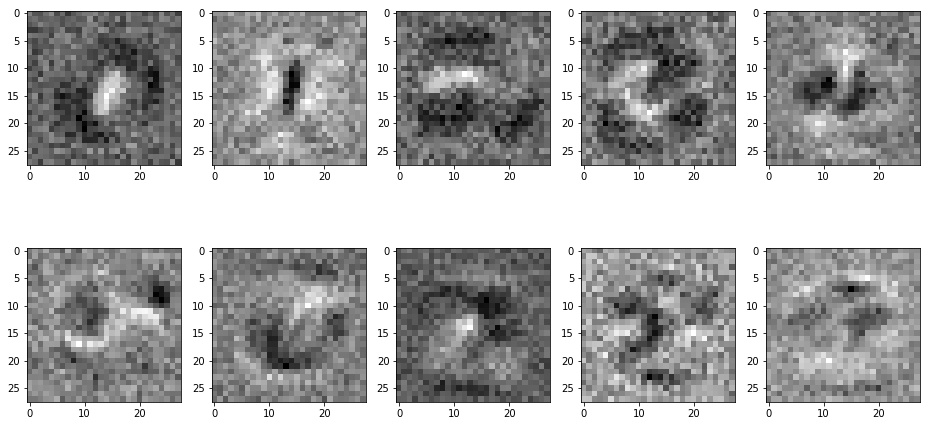

In [8]:
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    optimize(epochs=20, alph=0.1, batch_size=200)
    
    W_mat = sess.run(W).T
    
    fig = plt.figure(figsize=(16, 8))

    for i in range(2):
        for j in range(5):
            image = plt.subplot2grid((2, 5), (i, j))
            image.imshow(np.resize(W_mat[5*i + j], (28, 28)), cmap='gray_r')

    plt.show()

Точность регуляризацией сильно поднять не удалось. В матрице весов хотелось бы увидеть нечто похожее на соответствующие цифры, однако это больше выглядит как некие шумы. Попробуем приравнять к 0 веса близкие к 0, а оставшиеся к 1 чтобы посмотреть где находятся самые значимые веса.

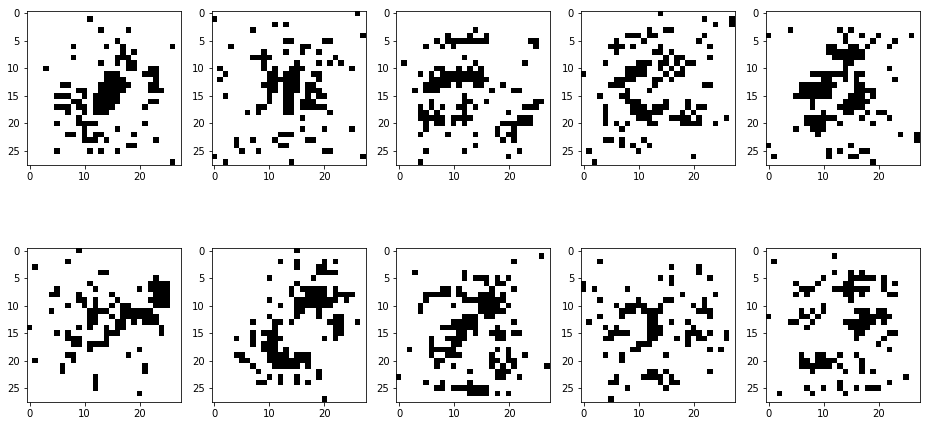

In [9]:
for row in W_mat:
    for i in range(len(row)):
        if np.abs(row[i]) < 0.18:
            row[i] = 0
        else:
            row[i] = 1
            
fig = plt.figure(figsize=(16, 8))

for i in range(2):
    for j in range(5):
        image = plt.subplot2grid((2, 5), (i, j))
        image.imshow(np.resize(W_mat[5*i + j], (28, 28)), cmap='gray_r')

plt.show()

Можно увидеть что самые значимые веса нашей матрицы группируются в середине картинки, а по бокам значения близкие к 0, это происходит так как по бокам картинок чаще всего лежат пустые пиксели и они содержат не так много информации важной для классификации (если убрать центрирование то это будет заметно даже лучше).

### 2. Universal approximation theorem

What if we add more layers to our model? Namely, we train two matrix $W_2$ and $W_1$
$$softmax(W_2\cdot(W_1x)).$$

At first glance adding more parameters helps to increase the generalizing ability of the model. Buy actually we have the same model $softmax(Wx)$, where $W = W_2\cdot W_1$. But everyting changes with adding ome more layer. Let's add nonlinear function $\sigma$ between $W_2$ and $W_1$

$$softmax(W_2\cdot \sigma(W_1x)).$$

Kurt Hornik showed in 1991 that it is not the specific choice of the nonlinear function, but rather the multilayer feedforward architecture itself which gives neural networks the potential of being universal approximators. The output units are always assumed to be linear. For notational convenience, only the single output case will be shown. The general case can easily be deduced from the single output case.

Let $\sigma(\cdot)$ be a nonconstant, bounded, and monotonically-increasing continuous function.
Let $\mathcal{S}_m \subset \mathbb{R}^m$ denote any compact set. 
Then, given any $\varepsilon > 0$ and any coninuous function $f$ on $\mathcal{S}_m$, there exist an integer $N$ and real constants $v_i$, $b_i$ amd real vectors $w_i$ that

$$\left| \sum _{i=1}^{N}v_{i}\sigma \left( w_i^{T} x+b_i \right) - f(x) \right| < \varepsilon, ~~~ \forall x \in \mathcal{S}_m.$$

The theorem has non-constructive proof, it meams that no estimates for $N$ and no method to find approximation's parameters.

#### Exercises
1. Let $\sigma$ – [heaviside step function](https://en.wikipedia.org/wiki/Heaviside_step_function) and $x \in \{0, 1\}^2$. Prove that $y = \sigma(wx + b)$ can approximate boolean function **OR** (hint: use constructive proof).
2. What about **AND** function?
3. Is it possible to implement **XOR**? Prove your words.
4. Prove that 2-layer network can implement any boolean function.

#### More useful facts:
1. A 2-layer network in in $\mathbb{R}^n$ allows to define convex polyhedron..
2. A 3-layer network in в $\mathbb{R}^n$ allows to define a not necessarily convex and not even necessarily connected area.

### 3. Backpropagation
Backpropagation is a method used to calculate the error contribution of each layer after a batch of data. It is a special case of an older and more general technique called automatic differentiation. In the context of learning, backpropagation is commonly used by the gradient descent optimization algorithm to adjust the weight of layers by calculating the gradient of the loss function. This technique is also sometimes called backward propagation of errors, because the error is calculated at the output and distributed back through the network layers. The main motivation of method is simplify evaluation of gradient which is complex problem for multilayer nets.

We need the following notation. Let $(y^1,\dots,y^n) = f(x^1,\dots,x^n)$ is some differentiable function and $\frac{dy}{dx}$ is matrix
$$\frac{dy}{dx} = \Big[ J_{ij} = \frac{\partial y^i}{\partial x^j} \Big]$$

Without violating the generality, we can assume that each layer is a function $x_{i} = f(x_{i-1}, w_i)$. As last layer we add loss function, so we can assume our multi-layer net as function $Q(x_0) = Q(f_n(f_{n-1}(\dots, w_{n-1}), w_n))$.

#### Forward step
Propagation forward through the network to generate the output values. Calculation of the loss function.

#### Backward step
Let's look at last layer. We can simply find $\frac{dQ}{dx_n}$. Now we can evaluate 

$$\frac{dQ}{dw_n} = \frac{dQ}{dx_n}\frac{dx_n}{dw_n} \text{ and } \frac{dQ}{dx_{n-1}} = \frac{dQ}{dx_n}\frac{dx_n}{dx_{n-1}}$$

Now we need calculate $\frac{dQ}{dw_{n-2}}$ и $\frac{dQ}{dx_{n-2}}$. But we have the same situation. We know $\frac{dQ}{dx_k}$, so can evaluate $\frac{dQ}{dw_k}$ and $\frac{dQ}{dx_{k-1}}$. Repeating this operation we find all the gradients. Now it's only remains to make a gradient step to update weights.

#### Exercises
1. Read more about [vanishing gradient](https://en.wikipedia.org/wiki/Vanishing_gradient_problem).
2. Train 2 layer net. Use sigmoid as nonlinearity.
3. Check accuracy on validation set.
4. Use [ReLu](https://en.wikipedia.org/wiki/Rectifier_(neural_networks) or LeakyReLu as nonlinearity. Compare accuracy and convergence with previous model.
5. Play with different architectures (add more layers, regularization and etc).
6. Show your best model.
7. How does quality change with adding layers. Prove your words, train model for 2, 3, 5, 7 and 10 layers.
8. Using backpropagation find optimal  digit 8 for your net.*

In [10]:
neuron_num = 50

graph = tf.Graph()
with graph.as_default():
    x = tf.placeholder(tf.float32, shape=[None, feature_num], name='Inputs')
    y_ = tf.placeholder(tf.int64, name='Answers')
    
    with tf.name_scope('First_layer'):
        W_1 = get_param([feature_num, neuron_num], 'Weights')
        b_1 = get_param([neuron_num], 'Bias')
        matmul_1 = tf.matmul(x, W_1) + b_1
        
        sigmoid = tf.sigmoid(matmul_1)
        
    with tf.name_scope('Second_layer'):
        W_2 = get_param([neuron_num, feature_num], 'Weights')
        b_2 = get_param([feature_num], 'Bias')
        matmul_2 = tf.matmul(sigmoid, W_2) + b_2
        
    with tf.name_scope('Evaluation'):
        check_prediction = tf.equal(tf.argmax(matmul_2,1), y_, name='Check_prediction')
        accuracy = tf.reduce_mean(tf.cast(check_prediction, tf.float32), name='Accuracy')
        
    with tf.name_scope('Loss_function'):
        loss_function = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_, logits=matmul_2), name='Loss')
        
    with tf.name_scope('Trainig_step'):
        alpha = tf.placeholder(tf.float32, name='Alpha')
        train_step = tf.train.GradientDescentOptimizer(alpha).minimize(loss_function)
        
writer = tf.summary.FileWriter("logs/2_layer_net")
writer.add_graph(graph)

In [11]:
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    optimize(epochs=30, alph=0.15, batch_size=100)

Качество модели на обучении: 0.942381
Качество модели на валидации: 0.941597
Качество модели на тестировании: 0.94127


In [12]:
graph = tf.Graph()
with graph.as_default():
    x = tf.placeholder(tf.float32, shape=[None, feature_num], name='Inputs')
    y_ = tf.placeholder(tf.int64, name='Answers')
    
    with tf.name_scope('First_layer'):
        W_1 = get_param([feature_num, neuron_num], 'Weights')
        b_1 = get_param([neuron_num], 'Bias')
        matmul_1 = tf.matmul(x, W_1) + b_1
        
        ReLu = tf.nn.relu(matmul_1)
        
    with tf.name_scope('Second_layer'):
        W_2 = get_param([neuron_num, feature_num], 'Weights')
        b_2 = get_param([feature_num], 'Bias')
        matmul_2 = tf.matmul(ReLu, W_2) + b_2
        
    with tf.name_scope('Evaluation'):
        check_prediction = tf.equal(tf.argmax(matmul_2,1), y_, name='Check_prediction')
        accuracy = tf.reduce_mean(tf.cast(check_prediction, tf.float32), name='Accuracy')
        
    with tf.name_scope('Loss_function'):
        loss_function = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_, logits=matmul_2), name='Loss')
        
    with tf.name_scope('Trainig_step'):
        alpha = tf.placeholder(tf.float32, name='Alpha')
        train_step = tf.train.GradientDescentOptimizer(alpha).minimize(loss_function)
        
writer = tf.summary.FileWriter("logs/2_layers_with_ReLu")
writer.add_graph(graph)

In [13]:
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    optimize(epochs=20, alph=0.05, batch_size=50)

Качество модели на обучении: 0.956905
Качество модели на валидации: 0.950008
Качество модели на тестировании: 0.946667


С ReLu сходится и быстрее и точнее. Посмотрим как покажет себя туториал "Deep mnist for Experts".

In [14]:
dropout_prob = 1

graph = tf.Graph()
with graph.as_default():
    x = tf.placeholder(tf.float32, shape=[None, feature_num], name='Inputs')
    y_ = tf.placeholder(tf.int64, name='Answers')
    
    images = tf.reshape(x, [-1, 28, 28, 1])

    with tf.name_scope('First_convolution_layer'):
        W_1 = get_param([5, 5, 1, 32], 'Weights')
        b_1 = get_param([32], 'Bias')
        
        conv_1 = tf.nn.conv2d(images, W_1, strides=[1, 1, 1, 1], padding='SAME') + b_1
        ReLu_1 = tf.nn.relu(conv_1, name='ReLu')
        
    max_pool_1 = tf.nn.max_pool(ReLu_1, ksize=[1, 2, 2, 1], 
                                strides=[1, 2, 2, 1], padding='SAME', name='First_max_pool')
    
    with tf.name_scope('Second_convolution_layer'):
        W_2 = get_param([5, 5, 32, 64], 'Weights')
        b_2 = get_param([64], 'Bias')
        
        conv_2 = tf.nn.conv2d(max_pool_1, W_2, strides=[1, 1, 1, 1], padding='SAME') + b_2
        ReLu_2 = tf.nn.relu(conv_2, name='ReLu')
        
    max_pool_2 = tf.nn.max_pool(ReLu_2, ksize=[1, 2, 2, 1], 
                                strides=[1, 2, 2, 1], padding='SAME', name='Second_max_pool')
    
    vectors = tf.reshape(max_pool_2, [-1, 7*7*64], name='Reshape')
    
    with tf.name_scope('Dance_layer'):
        W_3 = get_param([7*7*64, 1024], 'Weights')
        b_3 = get_param([1024], 'Bias')
        
        matmul_1 = tf.matmul(vectors, W_3) + b_3
        
        ReLu_3 = tf.sigmoid(matmul_1, name='ReLu')
        
    with tf.name_scope('Dropout'):
        Dropout = tf.nn.dropout(ReLu_3, dropout_prob)
        
    with tf.name_scope('Read_out_layer'):
        W_4 = get_param([1024, 10], 'Weights')
        b_4 = get_param([10], 'Bias')
        
        read_out = tf.matmul(Dropout, W_4, name='Read_out') + b_4
        
    with tf.name_scope('Evaluation'):
        check_prediction = tf.equal(tf.argmax(read_out,1), y_, name='Check_prediction')
        accuracy = tf.reduce_mean(tf.cast(check_prediction, tf.float32), name='Accuracy')
        
    with tf.name_scope('Loss_function'):
        loss_function = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_, logits=read_out), name='Loss')
        
    with tf.name_scope('Trainig_step'):
        alpha = tf.placeholder(tf.float32, name='Alpha')
        train_step = tf.train.GradientDescentOptimizer(alpha).minimize(loss_function)
        
writer = tf.summary.FileWriter("logs/Tensorflow_example")
writer.add_graph(graph)

In [16]:
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    optimize(epochs=10, alph=0.03, batch_size=100, info=True)

Эпоха номер: 1
Точность на обучении: 0.96
Точность на валидации: 0.935725 

Эпоха номер: 2
Точность на обучении: 0.98
Точность на валидации: 0.952547 

Эпоха номер: 3
Точность на обучении: 0.99
Точность на валидации: 0.958896 

Эпоха номер: 4
Точность на обучении: 0.99
Точность на валидации: 0.963498 

Эпоха номер: 5
Точность на обучении: 1.0
Точность на валидации: 0.966831 

Эпоха номер: 6
Точность на обучении: 1.0
Точность на валидации: 0.971433 

Эпоха номер: 7
Точность на обучении: 1.0
Точность на валидации: 0.972385 

Эпоха номер: 8
Точность на обучении: 1.0
Точность на валидации: 0.974449 

Эпоха номер: 9
Точность на обучении: 1.0
Точность на валидации: 0.976353 

Эпоха номер: 10
Точность на обучении: 1.0
Точность на валидации: 0.976829 

Качество модели на обучении: 0.981905
Качество модели на валидации: 0.976829
Качество модели на тестировании: 0.976191


Теперь попробуем сделать что нибудь покруче.

In [71]:
def coefficients(shape_W, shape_b, name_W=None, name_b=None):
    return get_param(shape_W, name_W), get_param(shape_b, name_b)

def conv(inputs, W, b, stride=1):
    return tf.nn.conv2d(inputs, W, strides=[1, stride, stride, 1], padding='SAME') + b

def max_pool(inputs, k_len, stride=1):
    return tf.nn.max_pool(inputs, ksize=[1, k_len, k_len, 1], strides=[1, stride, stride, 1], padding='SAME')

im_size = 28
in_depth_1 = 12
reduce_dim = 12
in_depth_2 = 21
neuron_num = 500
dropout_prob = 1.0

graph = tf.Graph()
with graph.as_default():
    x = tf.placeholder(tf.float32, shape=[None, feature_num], name='Inputs')
    y_ = tf.placeholder(tf.int64, name='Answers')
    
    images = tf.reshape(x, [-1, im_size, im_size, 1])
    
    with tf.name_scope('Naive_inception_module'):
        
        with tf.name_scope('1x1_Convolution'):
            W_in1_1x, b_in1_1x = coefficients([1, 1, 1, in_depth_1], [in_depth_1])
            conv_in1_1x = conv(images, W_in1_1x, b_in1_1x)
        
        with tf.name_scope('3x3_Convolution'):
            W_in1_3x, b_in1_3x = coefficients([3, 3, 1, in_depth_1], [in_depth_1])
            conv_in1_3x = conv(images, W_in1_3x, b_in1_3x)
            
        with tf.name_scope('5x5_Convolution'):
            W_in1_5x, b_in1_5x = coefficients([5, 5, 1, in_depth_1], [in_depth_1])
            conv_in1_5x = conv(images, W_in1_5x, b_in1_5x)
            
        max_pool_in1 = max_pool(images, 3)
        
        inception1 = tf.nn.relu(tf.concat([conv_in1_1x,conv_in1_3x,conv_in1_5x,max_pool_in1],3))
        
    first_max_pool = max_pool(inception1, 2, 2)
    
    im_size /= 2
        
    with tf.name_scope('Inception_module'):
        
        cur_depth = 3*in_depth_1 + 1
        
        with tf.name_scope('1x1_Convolution'):
            W_in2_1x, b_in2_1x = coefficients([1, 1, cur_depth, in_depth_2], [in_depth_2])
            conv_in2_1x = conv(first_max_pool, W_in2_1x, b_in2_1x)
        
        with tf.name_scope('3x3_Convolution'):
            W_in2_re_3x, b_in2_re_3x = coefficients([1, 1, cur_depth, reduce_dim], [reduce_dim])
            conv_in2_re_3x = conv(first_max_pool, W_in2_re_3x, b_in2_re_3x)
            
            W_in2_3x, b_in2_3x = coefficients([3, 3, reduce_dim, in_depth_2], [in_depth_2])
            conv_in2_3x = conv(conv_in2_re_3x, W_in2_3x, b_in2_3x)
            
        with tf.name_scope('5x5_Convolution'):
            W_in2_re_5x, b_in2_re_5x = coefficients([1, 1, cur_depth, reduce_dim], [reduce_dim])
            conv_in2_re_5x = conv(first_max_pool, W_in2_re_5x, b_in2_re_5x)
            
            W_in2_5x, b_in2_5x = coefficients([5, 5, reduce_dim, in_depth_2], [in_depth_2])
            conv_in2_5x = conv(conv_in2_re_5x, W_in2_5x, b_in2_5x)
            
        with tf.name_scope('Max_pool'):
            max_pool_in2 = max_pool(first_max_pool, 3)
            
            W_in2_re_mp, b_in2_re_mp = coefficients([1, 1, cur_depth, in_depth_2], [in_depth_2])
            conv_in2_re_mp = conv(max_pool_in2, W_in2_re_mp, b_in2_re_mp)
            
        inception2 = tf.nn.relu(tf.concat([conv_in2_1x,conv_in2_3x,conv_in2_5x,conv_in2_re_mp],3))
        
    second_max_pool = max_pool(inception2, 2, 2)
    
    im_size /= 2
    cur_depth = 4*in_depth_2
    
    vectors = tf.reshape(second_max_pool, [-1, 7*7*cur_depth], name='Reshape')
    
    with tf.name_scope('Dance_layer'):
        W_1, b_1 = coefficients([(49)*cur_depth, neuron_num], [neuron_num])
        matmul_1 = tf.matmul(vectors, W_1) + b_1
        
        ReLu_3 = tf.nn.relu(matmul_1, name='ReLu')
        
    with tf.name_scope('Dropout'):
        dropout = tf.nn.dropout(ReLu_3, dropout_prob)
        
    with tf.name_scope('Read_out_layer'):
        W_2, b_2 = coefficients([neuron_num, 10], [10])
        read_out = tf.matmul(dropout, W_2, name='Read_out') + b_2
        
    with tf.name_scope('Evaluation'):
        check_prediction = tf.equal(tf.argmax(read_out,1), y_, name='Check_prediction')
        accuracy = tf.reduce_mean(tf.cast(check_prediction, tf.float32), name='Accuracy')
        
    with tf.name_scope('Loss_function'):
        loss_function = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_, logits=read_out), name='Loss')
        
    with tf.name_scope('Trainig_step'):
        alpha = tf.placeholder(tf.float32, name='Alpha')
        train_step = tf.train.AdamOptimizer(alpha).minimize(loss_function)
            

writer = tf.summary.FileWriter("logs/govno_i_palki")
writer.add_graph(graph)

In [73]:
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    optimize(epochs=30, alph=0.001, batch_size=50, info=True)

Эпоха номер: 1
Точность на обучении: 0.96


ResourceExhaustedError: OOM when allocating tensor with shape[6301,28,28,37]
	 [[Node: Naive_inception_module/concat = ConcatV2[N=4, T=DT_FLOAT, Tidx=DT_INT32, _device="/job:localhost/replica:0/task:0/gpu:0"](Naive_inception_module/1x1_Convolution/add, Naive_inception_module/3x3_Convolution/add, Naive_inception_module/5x5_Convolution/add, Naive_inception_module/MaxPool, Naive_inception_module/concat/axis)]]
	 [[Node: Evaluation/Accuracy/_21 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_133_Evaluation/Accuracy", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'Naive_inception_module/concat', defined at:
  File "/home/roman/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/roman/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/roman/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/roman/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/roman/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/roman/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/roman/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/roman/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/roman/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/roman/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/roman/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/roman/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/roman/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/roman/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/roman/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/roman/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/roman/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/roman/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/roman/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/roman/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-71-699477f0473c>", line 40, in <module>
    inception1 = tf.nn.relu(tf.concat([conv_in1_1x,conv_in1_3x,conv_in1_5x,max_pool_in1],3))
  File "/home/roman/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1066, in concat
    name=name)
  File "/home/roman/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 493, in _concat_v2
    name=name)
  File "/home/roman/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/roman/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/roman/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[6301,28,28,37]
	 [[Node: Naive_inception_module/concat = ConcatV2[N=4, T=DT_FLOAT, Tidx=DT_INT32, _device="/job:localhost/replica:0/task:0/gpu:0"](Naive_inception_module/1x1_Convolution/add, Naive_inception_module/3x3_Convolution/add, Naive_inception_module/5x5_Convolution/add, Naive_inception_module/MaxPool, Naive_inception_module/concat/axis)]]
	 [[Node: Evaluation/Accuracy/_21 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_133_Evaluation/Accuracy", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


### 4. Autoencoders
An autoencoder is an network used for unsupervised learning of efficient codings. The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for the purpose of dimensionality reduction. Also, this technique can be used to train deep nets.

Architecturally, the simplest form of an autoencoder is a feedforward net very similar to the multilayer perceptron (MLP), but with the output layer having the same number of nodes as the input layer, and with the purpose of reconstructing its own inputs. Therefore, autoencoders are unsupervised learning models. An autoencoder always consists of two parts, the encoder and the decoder. Encoder returns latent representation of the object (compressed representation, usuallu smaller dimension), but decoder restores object from this latent representation. Autoencoders are also trained to minimise reconstruction errors (e.g. MSE).

Various techniques exist to prevent autoencoders from learning the identity and to improve their ability to capture important information:
1. Denoising autoencoder - take a partially corrupted input.
2. Sparse autoencoder - impose sparsity on the hidden units during training (whilst having a larger number of hidden units than inputs).
3. Variational autoencoder models inherit autoencoder architecture, but make strong assumptions concerning the distribution of latent variables.
4. Contractive autoencoder - add an explicit regularizer in objective function that forces the model to learn a function that is robust to slight variations of input values.

#### Exercises
1. Train 2 layers autoencoder that compressed mnist images to $\mathbb{R}^3$ space.
2. For each digit plot several samples in 3D axis (use "%matplotlib notebook" mode or plotly). How do digits group?
3. Train autoencoder with more layers. What are results?
4. Use autoencoder to pretrain 2 layers (unsupervised) and then train the following layers with supervised method.